In [1]:
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as imageio
import numpy as np
from heapq import heappush, heappop
from IPython.display import Video
import os
from os import listdir
from os.path import isfile, isdir, join
import time

startInstantTime = time.time()

In [2]:
#Parametros de ejecucion del programa
nombreArchivoInformacion = "./Datos/InformacionEjercicioTempladoSimulado.txt"
nombreArchivoAnimacion = "Animación del Templado Simulado [Aproximación a Camino más Corto entre 2 Nodos]"
coordenadaXPuntoInicial = 1
coordenadaYPuntoInicial = 2
coordenadaXPuntoFinal = 22
coordenadaYPuntoFinal = 23
temperaturaInicial = 1000.0
temperaturaFinal = 0.001
tasaEnfriamiento = 0.99
tiempoPausaAnimacion = 0.001

searchFolderPath = "./Figuras/"
imageFileExtension = ".jpg"
animationFileExtension = ".mp4"
framesPorSegundoAnimacion = 15

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [3]:
imageFileExtensionsList = [imageFileExtension]

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

def getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    filesList.sort(key = lambda file: os.path.getmtime(join(searchFolderPath, file)))
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    return filesList, informativeMessage

def deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    
    for file in filesList:
        os.remove(join(searchFolderPath, file))
    return informativeMessage

def resizeImage(image, width = None, height = None, interpolationTechnique = cv2.INTER_AREA):
    newImageSize = None
    ratioFactor = 1.0
    (imageHeight, imageWidth) = image.shape[:2]
    
    #The ratio factor is computed (only in case to get exactly one of the parameters (width or height) in None), otherwise, the image will be resized without keep its aspect ratio
    if width is None and height is None:
        return image
    if width is None:
        ratioFactor = height / float(imageHeight)
        newImageSize = (int(imageWidth * ratioFactor), height)
    elif height is None:
        ratioFactor = width / float(imageWidth)
        newImageSize = (width, int(imageHeight * ratioFactor))
    else:
        newImageSize = (width, height)
    resizedImage = cv2.resize(image, newImageSize, interpolation = interpolationTechnique)
    return resizedImage

#El ajuste de tamaño comun a las imagenes esta hecho con reescalado al tamaño maximo/minimo o con un slice/recorte al tamaño minimo
def overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList):
    numberImageFilesFound = len(imageFilesList)
    if numberImageFilesFound >= 1:
        maximumWidthForAllImages = -1
        maximumHeightForAllImages = -1
        #minimumWidthForAllImages = float('inf')
        #minimumHeightForAllImages = float('inf')
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImageWidth = originalImage.shape[1]
            originalImageHeight = originalImage.shape[0]
            if originalImageWidth > maximumWidthForAllImages:
                maximumWidthForAllImages = originalImageWidth
            if originalImageHeight > maximumHeightForAllImages:
                maximumHeightForAllImages = originalImageHeight
            #if originalImageWidth < minimumWidthForAllImages:
                #minimumWidthForAllImages = originalImageWidth
            #if originalImageHeight < minimumHeightForAllImages:
                #minimumHeightForAllImages = originalImageHeight
        
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImage = resizeImage(originalImage, width = maximumWidthForAllImages, height = maximumHeightForAllImages)
            #originalImage = originalImage[0:minimumHeightForAllImages, 0:minimumWidthForAllImages]
            cv2.imwrite(join(searchFolderPath, imageFile), originalImage)
        print("Se ha(n) ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(maximumWidthForAllImages) + "x" + str(maximumHeightForAllImages), colorTextoVerde) + " como máximo de ancho por máximo de alto")
        #print("Se ha(n) ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(minimumWidthForAllImages) + "x" + str(minimumHeightForAllImages), colorTextoVerde) + " como mínimo de ancho por mínimo de alto")
    else:
        print(printColouredText("La lista dada está vacía", colorTextoRojo))

def createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, animationFilename, animationFileExtension, frameRate):
    imageFilesList, informativeMessage = getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList)
    animationFilePath = join(searchFolderPath, animationFilename + animationFileExtension)
    
    writerStream = imageio.get_writer(animationFilePath, fps = frameRate)
    for imageFile in imageFilesList:
        writerStream.append_data(imageio.imread(join(searchFolderPath, imageFile)))
    writerStream.close()
    print("Se ha creado el archivo", printColouredText(animationFilePath, colorTextoVerde))
    return animationFilePath

#Funcion hash para mapear de una coordenada (x, y) de una malla de puntos equidistantes a un numero natural
def hashCoordenadaANumero(valorCoordenadaX, valorCoordenadaY, numeroVerticesAlto, numeroVerticesAncho):
    return valorCoordenadaX + valorCoordenadaY * numeroVerticesAlto

#Funcion hash para mapear de un numero natural a una coordenada (x, y) de una malla de puntos equidistantes
def hashNumeroACoordenada(numeroIdentificador, numeroVerticesAlto, numeroVerticesAncho):
    valorCoordenadaX = numeroIdentificador % numeroVerticesAncho
    valorCoordenadaY = int(numeroIdentificador / numeroVerticesAncho)
    return valorCoordenadaX, valorCoordenadaY

def crearAristaEnGrafoNoDirigido(grafo, nodoOrigen, nodoDestino, costo = 1.0):
    if nodoOrigen not in grafo:
        grafo[nodoOrigen] = {}
    grafo[nodoOrigen][nodoDestino] = costo
    if nodoDestino not in grafo:
        grafo[nodoDestino] = {}
    grafo[nodoDestino][nodoOrigen] = costo

def actualizarHeap(heap, d, v):
    for indice in range(len(heap)):
        if heap[indice][1] == v:
            heap[indice][0] = d
            ajustarHeapAHeapMinimal(heap, indice) #Esta instruccion se puede reemplazar por heap = heapify(heap) pero es ineficiente
            break

def ajustarHeapAHeapMinimal(heap, indice):
    if indice == 0:
        return
    indicePredecesorInmediato = int(indice / 2)
    if indicePredecesorInmediato >= 0 and heap[indicePredecesorInmediato][0] > heap[indice][0]:
        heap[indice], heap[indicePredecesorInmediato] = heap[indicePredecesorInmediato], heap[indice]
        ajustarHeapAHeapMinimal(heap, indicePredecesorInmediato)

def algoritmoDijkstra(grafo, nodoOrigen):
    diccionarioDistanciasDesdeNodoOrigen = {}
    for nodoEntrada in grafo:
        diccionarioDistanciasDesdeNodoOrigen[nodoEntrada] = float('inf')
    diccionarioDistanciasDesdeNodoOrigen[nodoOrigen] = 0
    
    diccionarioNodosPredecesores = {}
    heapMinimalDistanciasYNodos = []
    for nodoEntrada in grafo:
        item = []
        item.append(diccionarioDistanciasDesdeNodoOrigen[nodoEntrada])
        item.append(nodoEntrada)
        heappush(heapMinimalDistanciasYNodos, item)
    
    #S = []
    while heapMinimalDistanciasYNodos:
        u = heappop(heapMinimalDistanciasYNodos)[1]
        #S.append(u)
        for v in grafo[u]:
            distanciaTentativa = diccionarioDistanciasDesdeNodoOrigen[u] + grafo[u][v]
            if distanciaTentativa < diccionarioDistanciasDesdeNodoOrigen[v]:
                diccionarioNodosPredecesores[v] = u
                diccionarioDistanciasDesdeNodoOrigen[v] = distanciaTentativa
                actualizarHeap(heapMinimalDistanciasYNodos, diccionarioDistanciasDesdeNodoOrigen[v], v)
    return diccionarioDistanciasDesdeNodoOrigen, diccionarioNodosPredecesores

def construirCaminoMasCortoEntreNodosGrafo(grafo, nodoOrigen, nodoDestino):
    diccionarioDistanciasDesdeNodoOrigen, diccionarioNodosPredecesores = algoritmoDijkstra(grafo, nodoOrigen)
    caminoEncontrado = []
    while True:
        caminoEncontrado.append(nodoDestino)
        if nodoDestino == nodoOrigen:
            break
        nodoDestino = diccionarioNodosPredecesores[nodoDestino]
    caminoEncontrado.reverse()
    return caminoEncontrado

def crearTextoDescriptorSucesionElementos(listaElementos, separador = " "):
    textoSucesionElementosLista = ""
    for indice in range(len(listaElementos) - 1):
        textoSucesionElementosLista += str(listaElementos[indice]) + separador
    textoSucesionElementosLista += str(listaElementos[len(listaElementos) - 1])
    return textoSucesionElementosLista

def calcularCostoCaminoEnGrafo(grafo, listaNodosCamino):
    costoTotalCamino = 0.0
    for indice in range(len(listaNodosCamino) - 1):
        costoTotalCamino += grafo[listaNodosCamino[indice]][listaNodosCamino[indice + 1]]
    return costoTotalCamino

def obtenerListasCoordendasNodosGrafo(grafo, numeroVerticesAlto, numeroVerticesAncho):
    listaValoresCoordenadaX = []
    listaValoresCoordenadaY = []
    listaNodosVisitadosGrafo = []
    for nodoOrigen in grafo:
        for nodoDestino in grafo[nodoOrigen]:
            if nodoOrigen not in listaNodosVisitadosGrafo:
                listaNodosVisitadosGrafo.append(nodoOrigen)
                valorCoordenadaXNodoActual, valorCoordenadaYNodoActual = hashNumeroACoordenada(nodoOrigen, numeroVerticesAlto, numeroVerticesAncho)
                listaValoresCoordenadaX.append(valorCoordenadaXNodoActual)
                listaValoresCoordenadaY.append(valorCoordenadaYNodoActual)
            if nodoDestino not in listaNodosVisitadosGrafo:
                listaNodosVisitadosGrafo.append(nodoDestino)
                valorCoordenadaXNodoActual, valorCoordenadaYNodoActual = hashNumeroACoordenada(nodoDestino, numeroVerticesAlto, numeroVerticesAncho)
                listaValoresCoordenadaX.append(valorCoordenadaXNodoActual)
                listaValoresCoordenadaY.append(valorCoordenadaYNodoActual)
    return listaValoresCoordenadaX, listaValoresCoordenadaY

def obtenerListasCoordenadasCaminoGrafo(listaNodosCamino, numeroVerticesAlto, numeroVerticesAncho):
    listaPuntosCamino = []
    listaValoresCoordenadasEjeX = []
    listaValoresCoordenadasEjeY = []
    for nodoActual in listaNodosCamino:
        coordenadaXNodoActual, coordenadaYNodoActual = hashNumeroACoordenada(nodoActual, numeroVerticesAlto, numeroVerticesAncho)
        listaValoresCoordenadasEjeX.append(coordenadaXNodoActual)
        listaValoresCoordenadasEjeY.append(coordenadaYNodoActual)
        listaPuntosCamino.append((coordenadaXNodoActual, coordenadaYNodoActual))
    return listaPuntosCamino, listaValoresCoordenadasEjeX, listaValoresCoordenadasEjeY

def dibujarAristasGrafoEnPlanoCartesiano(grafo, informacionAristasGrafo):
    transparenciaAristasGrafo = 0.85
    for nodoOrigen in grafo:
        for nodoDestino in grafo[nodoOrigen]:
            if nodoOrigen < nodoDestino:
                valorCoordenadaXNodoOrigen, valorCoordenadaYNodoOrigen = hashNumeroACoordenada(nodoOrigen, numeroVerticesAlto, numeroVerticesAncho)
                valorCoordenadaXNodoDestino, valorCoordenadaYNodoDestino = hashNumeroACoordenada(nodoDestino, numeroVerticesAlto, numeroVerticesAncho)
                colorArista = informacionAristasGrafo[(nodoOrigen, nodoDestino)]["color"]
                plt.plot([valorCoordenadaXNodoOrigen, valorCoordenadaXNodoDestino], [valorCoordenadaYNodoOrigen, valorCoordenadaYNodoDestino], '', c = colorArista, alpha = transparenciaAristasGrafo)

In [4]:
#Se propone un camino en el grafo que inicia en un nodo de origen y termina en un nodo de destino dados, a traves de una exploracion del grafo de forma aleatoria
def generarCaminoEntreNodosGrafo(grafo, nodoOrigen, nodoDestino, listaNodosAExcluir = []):
    listaNodosCaminoPropuesto = [nodoOrigen]
    listaNodosInaccesibles = listaNodosAExcluir
    nodoActual = nodoOrigen
    while nodoActual != nodoDestino:
        #Se quiere saber si todos los vecinos al nodo actual son inaccesibles, es decir, si todos los vecinos estan en la ruta propuesta o en la lista de nodos inaccesibles
        todosLosVecinosNodoActualSonInaccesibles = True
        for nodoVecino in grafo[nodoActual]:
            if nodoVecino not in listaNodosCaminoPropuesto and nodoVecino not in listaNodosInaccesibles:
                todosLosVecinosNodoActualSonInaccesibles = False
                break
        
        #Si todos los vecinos al nodo actual son inaccesibles, se elimina el nodo actual de la ruta, se anade el nodo actual a la lista de nodos inaccesibles y se considera el ultimo nodo de la ruta como nodo actual para continuar formando la ruta
        if todosLosVecinosNodoActualSonInaccesibles:
            listaNodosCaminoPropuesto = listaNodosCaminoPropuesto[0:len(listaNodosCaminoPropuesto) - 1]
            listaNodosInaccesibles.append(nodoActual)
            nodoActual = listaNodosCaminoPropuesto[len(listaNodosCaminoPropuesto) - 1]
            continue

        #En caso de que haya un nodo vecino que se pueda escoger para formar la ruta se escoge al azar un nodo para agregarlo a la ruta de tal forma que no este en la ruta y no este en la lista de nodos inaccesibles y luego considerar como nodo actual al nodo que se agrego
        indiceNodoCandidatoANodoSiguiente = np.random.randint(len(grafo[nodoActual]))
        indiceTemporal = 0
        nodoSiguiente = None
        for nodoVecino in grafo[nodoActual]:
            if indiceTemporal == indiceNodoCandidatoANodoSiguiente:
                nodoSiguiente = nodoVecino
                break
            else:
                indiceTemporal += 1
        
        while nodoSiguiente in listaNodosCaminoPropuesto or nodoSiguiente in listaNodosInaccesibles:
            indiceNodoCandidatoANodoSiguiente = np.random.randint(len(grafo[nodoActual]))
            indiceTemporal = 0
            nodoSiguiente = None
            for nodoVecino in grafo[nodoActual]:
                if indiceTemporal == indiceNodoCandidatoANodoSiguiente:
                    nodoSiguiente = nodoVecino
                    break
                else:
                    indiceTemporal += 1
        listaNodosCaminoPropuesto.append(nodoSiguiente)
        nodoActual = nodoSiguiente
    return listaNodosCaminoPropuesto

#Se propone como forma de modificar un camino propuesto: Se considera el subcamino para a y c como un camino valido y se propone un nuevo camino para c y b donde c es un nodo intermedio de la ruta propuesta tal que c != a y c != b
def modificarCaminoEntreNodosGrafo(grafo, listaNodosCaminoPropuesto):
    indiceNodoCorte = np.random.randint(len(listaNodosCaminoPropuesto) - 2)
    listaNodosCaminoModificado = []
    for indice in range(indiceNodoCorte + 1):
        listaNodosCaminoModificado.append(listaNodosCaminoPropuesto[indice])
    listaNodosSubcaminoFinal = generarCaminoEntreNodosGrafo(grafo, listaNodosCaminoPropuesto[indiceNodoCorte + 1], listaNodosCaminoPropuesto[len(listaNodosCaminoPropuesto) - 1], listaNodosAExcluir = listaNodosCaminoPropuesto[0:(indiceNodoCorte + 1)])
    for nodo in listaNodosSubcaminoFinal:
        listaNodosCaminoModificado.append(nodo)
    return listaNodosCaminoModificado

#A partir del templado simulado, se calcula la probabilidad de aceptacion de una nueva solucion segun su energia
def calcularProbabilidadAceptacionNuevaSolucion(energiaSolucionActual, energiaNuevaSolucion, temperatura):
    if energiaNuevaSolucion < energiaSolucionActual:
        return 1.0
    return np.exp((energiaSolucionActual - energiaNuevaSolucion) / temperatura)

def algoritmoTempladoSimulado(grafo, listaNodosCaminoPropuestoInicialmenteOrigenADestino, listaValoresCoordenadasEjeXCaminoMasCortoOrigenADestino, listaValoresCoordenadasEjeYCaminoMasCortoOrigenADestino, energiaSolucionOptima, temperaturaInicial, temperaturaFinal, tasaEnfriamiento):
    listaValoresCoordenadasEjeXMejorCaminoPropuestoOrigenADestino = []
    listaValoresCoordenadasEjeYMejorCaminoPropuestoOrigenADestino = []
    listaValoresCoordenadasEjeXCaminoPropuestoOrigenADestino = []
    listaValoresCoordenadasEjeYCaminoPropuestoOrigenADestino = []
    
    mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    print(printColouredText(mensajeConfirmacion, colorTextoRojo))
    temperaturaActual = temperaturaInicial
    listaNodosCaminoPropuestoOrigenADestino = listaNodosCaminoPropuestoInicialmenteOrigenADestino
    listaNodosMejorCaminoPropuestoOrigenADestino = listaNodosCaminoPropuestoInicialmenteOrigenADestino
    costoMejorCaminoPropuestoOrigenADestino = calcularCostoCaminoEnGrafo(grafo, listaNodosMejorCaminoPropuestoOrigenADestino)
    listaValoresEnergiaSolucionPropuesta = []
    listaValoresEnergiaMejorSolucionPropuesta = []
    numeroPasos = 0
    
    plt.figure(num = 2, figsize = (9, 8))
    plt.ion()
    while temperaturaActual > temperaturaFinal:
        plt.clf()
        
        #Se actualiza el camino propuesto y se calcula la energia de las soluciones (en este caso la energia es el costo del camino)
        listaNodosCaminoModificadoOrigenADestino = modificarCaminoEntreNodosGrafo(grafo, listaNodosCaminoPropuestoOrigenADestino)
        costoCaminoPropuestoOrigenADestino = calcularCostoCaminoEnGrafo(grafo, listaNodosCaminoPropuestoOrigenADestino)
        costoCaminoModificadoOrigenADestino = calcularCostoCaminoEnGrafo(grafo, listaNodosCaminoModificadoOrigenADestino)
        
        #Se decide si se acepta el camino modificado o no como posible mejora al camino propuesto
        probabilidadAceptacionCaminoModificadoOrigenADestino = calcularProbabilidadAceptacionNuevaSolucion(costoCaminoPropuestoOrigenADestino, costoCaminoModificadoOrigenADestino, temperaturaActual)
        if probabilidadAceptacionCaminoModificadoOrigenADestino > np.random.rand():
            listaNodosCaminoPropuestoOrigenADestino = listaNodosCaminoModificadoOrigenADestino
            costoCaminoPropuestoOrigenADestino = calcularCostoCaminoEnGrafo(grafo, listaNodosCaminoPropuestoOrigenADestino)
        
        #Se verifica si se actualiza el camino propuesto como el mejor camino encontrado
        if costoCaminoPropuestoOrigenADestino < costoMejorCaminoPropuestoOrigenADestino:
            listaNodosMejorCaminoPropuestoOrigenADestino = listaNodosCaminoPropuestoOrigenADestino
        costoMejorCaminoPropuestoOrigenADestino = calcularCostoCaminoEnGrafo(grafo, listaNodosMejorCaminoPropuestoOrigenADestino)
        
        temperaturaActual *= tasaEnfriamiento #Se enfria el sistema
        
        listaValoresEnergiaSolucionPropuesta.append(costoCaminoPropuestoOrigenADestino)
        listaValoresEnergiaMejorSolucionPropuesta.append(costoMejorCaminoPropuestoOrigenADestino)
        listaPuntosMejorCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeXMejorCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYMejorCaminoPropuestoOrigenADestino = obtenerListasCoordenadasCaminoGrafo(listaNodosMejorCaminoPropuestoOrigenADestino, numeroVerticesAlto, numeroVerticesAncho)
        listaPuntosCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeXCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYCaminoPropuestoOrigenADestino = obtenerListasCoordenadasCaminoGrafo(listaNodosCaminoPropuestoOrigenADestino, numeroVerticesAlto, numeroVerticesAncho)
        
        plt.plot(listaValoresCoordenadasEjeXCaminoMasCortoOrigenADestino, listaValoresCoordenadasEjeYCaminoMasCortoOrigenADestino, 'm-', label = 'Camino más Corto', linewidth = 9)
        plt.plot(listaValoresCoordenadasEjeXCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYCaminoPropuestoOrigenADestino, 'c-', label = 'Último Camino Propuesto', linewidth = 5)
        plt.plot(listaValoresCoordenadasEjeXMejorCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYMejorCaminoPropuestoOrigenADestino, 'w-', label = 'Mejor Camino Propuesto', linewidth = 5)
        dibujarAristasGrafoEnPlanoCartesiano(grafo, informacionAristasGrafo)
        plt.plot(listaValoresCoordenadasEjeX, listaValoresCoordenadasEjeY, 'w.', markersize = 14)
        plt.plot([coordenadaXPuntoInicial, coordenadaXPuntoFinal], [coordenadaYPuntoInicial, coordenadaYPuntoFinal], 'c.', markersize = 35)
        plt.legend(bbox_to_anchor = (0.0, 1.0, 1.0, 0.0), labelcolor = 'w', loc = 3, ncol = 3, mode = 'expand', borderaxespad = 0.5)
        
        numeroPasos += 1
        plt.pause(tiempoPausaAnimacion)
        rutaArchivoImagenActual = searchFolderPath + 'Frame ' + str(numeroPasos) + imageFileExtension
        plt.savefig(rutaArchivoImagenActual, bbox_inches = 'tight')
        plt.show()
    plt.ioff()
    plt.show()
    return listaNodosMejorCaminoPropuestoOrigenADestino, listaNodosCaminoPropuestoOrigenADestino, listaValoresEnergiaSolucionPropuesta, listaValoresEnergiaMejorSolucionPropuesta, costoMejorCaminoPropuestoOrigenADestino

In [5]:
grafo = {}
informacionAristasGrafo = {}
numeroVerticesAlto = None
numeroVerticesAncho = None

#Lectura linea por linea del archivo, en la primera linea se tiene el numero de vertices de alto del grafo de malla, en la segunda linea se tiene el numero de vertices de ancho del grafo de malla, en las demas lineas se tienen separados por espacios los datos de cada arista (Nodo origen, nodo destino, costo y color asignado)
inputStream = open(nombreArchivoInformacion, "r")
listaNodosEncontrados = []
lineasTextoArchivo = inputStream.readlines()
for indice in range(len(lineasTextoArchivo)):
    if indice == 0:
        numeroVerticesAlto = int(lineasTextoArchivo[indice].strip())
    elif indice == 1:
        numeroVerticesAncho = int(lineasTextoArchivo[indice].strip())
    else:
        datosArista = lineasTextoArchivo[indice].strip().split(" ")
        nodoOrigen = int(datosArista[0])
        nodoDestino = int(datosArista[1])
        costo = float(datosArista[2])
        colorArista = datosArista[3]
        crearAristaEnGrafoNoDirigido(grafo, nodoOrigen, nodoDestino, costo)
        informacionAristasGrafo[(nodoOrigen, nodoDestino)] = {"costo": costo, "color": colorArista}
        
        if nodoOrigen not in listaNodosEncontrados:
            listaNodosEncontrados.append(nodoOrigen)
        if nodoDestino not in listaNodosEncontrados:
            listaNodosEncontrados.append(nodoDestino)
numeroNodosEncontrados = len(listaNodosEncontrados)
numeroAristasEncontradas = len(list(informacionAristasGrafo.keys()))
inputStream.close()

print("Se ha extraído la información del grafo del archivo", printColouredText(nombreArchivoInformacion, colorTextoVerde))
print("El grafo contiene", printColouredText(str(numeroNodosEncontrados) + " nodos", colorTextoVerde), "y", printColouredText(str(numeroAristasEncontradas) + " aristas", colorTextoVerde))
print("Se va a buscar una solución al camino más corto entre los puntos", printColouredText(str((coordenadaXPuntoInicial, coordenadaYPuntoInicial)), colorTextoRojo), "y", printColouredText(str((coordenadaXPuntoFinal, coordenadaYPuntoFinal)), colorTextoRojo))

Se ha extraído la información del grafo del archivo ./Datos/InformacionEjercicioTempladoSimulado.txt
El grafo contiene 625 nodos y 1200 aristas
Se va a buscar una solución al camino más corto entre los puntos (1, 2) y (22, 23)


In [6]:
nodoOrigen = hashCoordenadaANumero(coordenadaXPuntoInicial, coordenadaYPuntoInicial, numeroVerticesAlto, numeroVerticesAncho)
nodoDestino = hashCoordenadaANumero(coordenadaXPuntoFinal, coordenadaYPuntoFinal, numeroVerticesAlto, numeroVerticesAncho)

listaNodosCaminoMasCortoOrigenADestino = construirCaminoMasCortoEntreNodosGrafo(grafo, nodoOrigen, nodoDestino)
listaPuntosCaminoMasCortoOrigenADestino, listaValoresCoordenadasEjeXCaminoMasCortoOrigenADestino, listaValoresCoordenadasEjeYCaminoMasCortoOrigenADestino = obtenerListasCoordenadasCaminoGrafo(listaNodosCaminoMasCortoOrigenADestino, numeroVerticesAlto, numeroVerticesAncho)
textoCaminoMasCortoOrigenADestino = crearTextoDescriptorSucesionElementos(listaPuntosCaminoMasCortoOrigenADestino, separador = " -> ")
costoCaminoMasCortoOrigenADestino = calcularCostoCaminoEnGrafo(grafo, listaNodosCaminoMasCortoOrigenADestino)
print("El camino más corto (o uno de los caminos de mínimo costo) entre los puntos", printColouredText(str((coordenadaXPuntoInicial, coordenadaYPuntoInicial)), colorTextoVerde), "y", printColouredText(str((coordenadaXPuntoFinal, coordenadaYPuntoFinal)), colorTextoVerde), "es:")
print(printColouredText(textoCaminoMasCortoOrigenADestino, colorTextoRojo))
print("El camino más corto (o uno de los caminos de mínimo costo) entre los puntos", printColouredText(str((coordenadaXPuntoInicial, coordenadaYPuntoInicial)), colorTextoVerde), "y", printColouredText(str((coordenadaXPuntoFinal, coordenadaYPuntoFinal)), colorTextoVerde), "tiene una distancia total de", printColouredText(str(costoCaminoMasCortoOrigenADestino), colorTextoVerde), "y pasa por", printColouredText(str(len(listaNodosCaminoMasCortoOrigenADestino)), colorTextoVerde), "nodos")

El camino más corto (o uno de los caminos de mínimo costo) entre los puntos (1, 2) y (22, 23) es:
(1, 2) -> (1, 3) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (13, 5) -> (13, 6) -> (14, 6) -> (15, 6) -> (16, 6) -> (17, 6) -> (17, 7) -> (18, 7) -> (19, 7) -> (19, 8) -> (20, 8) -> (20, 9) -> (20, 10) -> (20, 11) -> (21, 11) -> (21, 12) -> (21, 13) -> (21, 14) -> (21, 15) -> (21, 16) -> (21, 17) -> (21, 18) -> (21, 19) -> (21, 20) -> (21, 21) -> (21, 22) -> (22, 22) -> (22, 23)
El camino más corto (o uno de los caminos de mínimo costo) entre los puntos (1, 2) y (22, 23) tiene una distancia total de 52.809999999999995 y pasa por 43 nodos


In [7]:
numeroIteraciones = int(np.ceil((np.log10(temperaturaFinal) - np.log10(temperaturaInicial)) / np.log10(tasaEnfriamiento)))
listaNodosCaminoPropuestoOrigenADestino = generarCaminoEntreNodosGrafo(grafo, nodoOrigen, nodoDestino)
listaPuntosCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeXCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYCaminoPropuestoOrigenADestino = obtenerListasCoordenadasCaminoGrafo(listaNodosCaminoPropuestoOrigenADestino, numeroVerticesAlto, numeroVerticesAncho)
costoCaminoPropuestoOrigenADestino = calcularCostoCaminoEnGrafo(grafo, listaNodosCaminoPropuestoOrigenADestino)
print("La animación termina después de", printColouredText(str(numeroIteraciones), colorTextoVerde), "iteraciones")
print("El camino entre los puntos", printColouredText(str((coordenadaXPuntoInicial, coordenadaYPuntoInicial)), colorTextoVerde), "y", printColouredText(str((coordenadaXPuntoFinal, coordenadaYPuntoFinal)), colorTextoVerde), "propuesto inicialmente tiene una distancia total de", printColouredText(str(costoCaminoPropuestoOrigenADestino), colorTextoVerde), "y pasa por", printColouredText(str(len(listaNodosCaminoPropuestoOrigenADestino)), colorTextoVerde), "nodos")

La animación termina después de 1375 iteraciones
El camino entre los puntos (1, 2) y (22, 23) propuesto inicialmente tiene una distancia total de 270.2799999999999 y pasa por 183 nodos


<IPython.core.display.Javascript object>


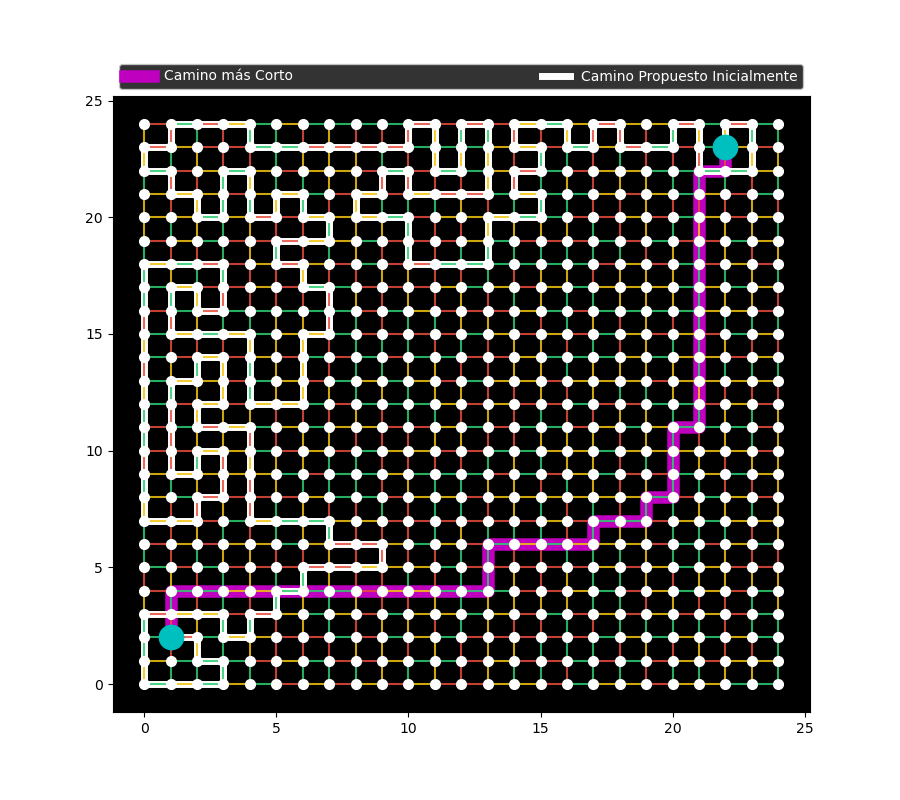

In [8]:
%matplotlib notebook

listaValoresCoordenadasEjeX, listaValoresCoordenadasEjeY = obtenerListasCoordendasNodosGrafo(grafo, numeroVerticesAlto, numeroVerticesAncho)

plt.rcParams['axes.facecolor'] = 'black'
plt.figure(num = 1, figsize = (9, 8))
plt.plot(listaValoresCoordenadasEjeXCaminoMasCortoOrigenADestino, listaValoresCoordenadasEjeYCaminoMasCortoOrigenADestino, 'm-', label = 'Camino más Corto', linewidth = 9)
plt.plot(listaValoresCoordenadasEjeXCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYCaminoPropuestoOrigenADestino, 'w-', label = 'Camino Propuesto Inicialmente', linewidth = 5)
dibujarAristasGrafoEnPlanoCartesiano(grafo, informacionAristasGrafo)
plt.plot(listaValoresCoordenadasEjeX, listaValoresCoordenadasEjeY, 'w.', markersize = 14)
plt.plot([coordenadaXPuntoInicial, coordenadaXPuntoFinal], [coordenadaYPuntoInicial, coordenadaYPuntoFinal], 'c.', markersize = 35)
plt.legend(bbox_to_anchor = (0.0, 1.0, 1.0, 0.0), labelcolor = 'w', loc = 3, ncol = 2, mode = 'expand', borderaxespad = 0.5)
plt.show()

No hay archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


<IPython.core.display.Javascript object>


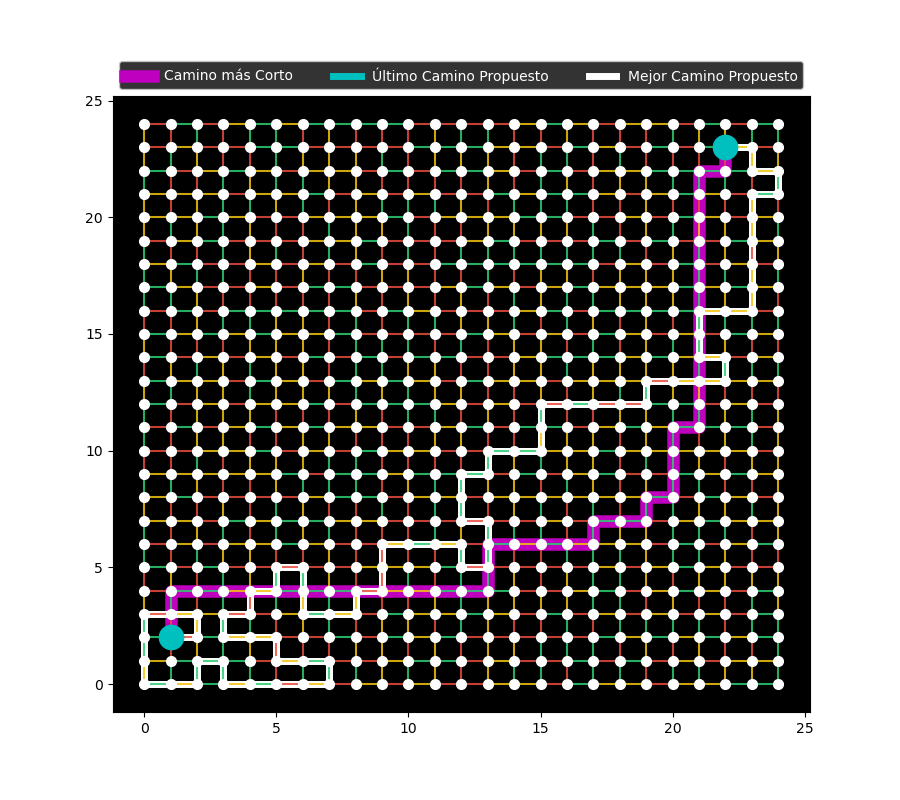

In [9]:
listaNodosMejorCaminoPropuestoOrigenADestino, listaNodosUltimoCaminoPropuestoOrigenADestino, listaValoresEnergiaUltimaSolucionPropuesta, listaValoresEnergiaMejorSolucionPropuesta, costoMejorCaminoPropuestoOrigenADestino = algoritmoTempladoSimulado(grafo, listaNodosCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeXCaminoMasCortoOrigenADestino, listaValoresCoordenadasEjeYCaminoMasCortoOrigenADestino, costoCaminoMasCortoOrigenADestino, temperaturaInicial, temperaturaFinal, tasaEnfriamiento)
listaPuntosMejorCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeXMejorCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYMejorCaminoPropuestoOrigenADestino = obtenerListasCoordenadasCaminoGrafo(listaNodosMejorCaminoPropuestoOrigenADestino, numeroVerticesAlto, numeroVerticesAncho)
listaPuntosUltimoCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeXUltimoCaminoPropuestoOrigenADestino, listaValoresCoordenadasEjeYUltimoCaminoPropuestoOrigenADestino = obtenerListasCoordenadasCaminoGrafo(listaNodosUltimoCaminoPropuestoOrigenADestino, numeroVerticesAlto, numeroVerticesAncho)

<IPython.core.display.Javascript object>


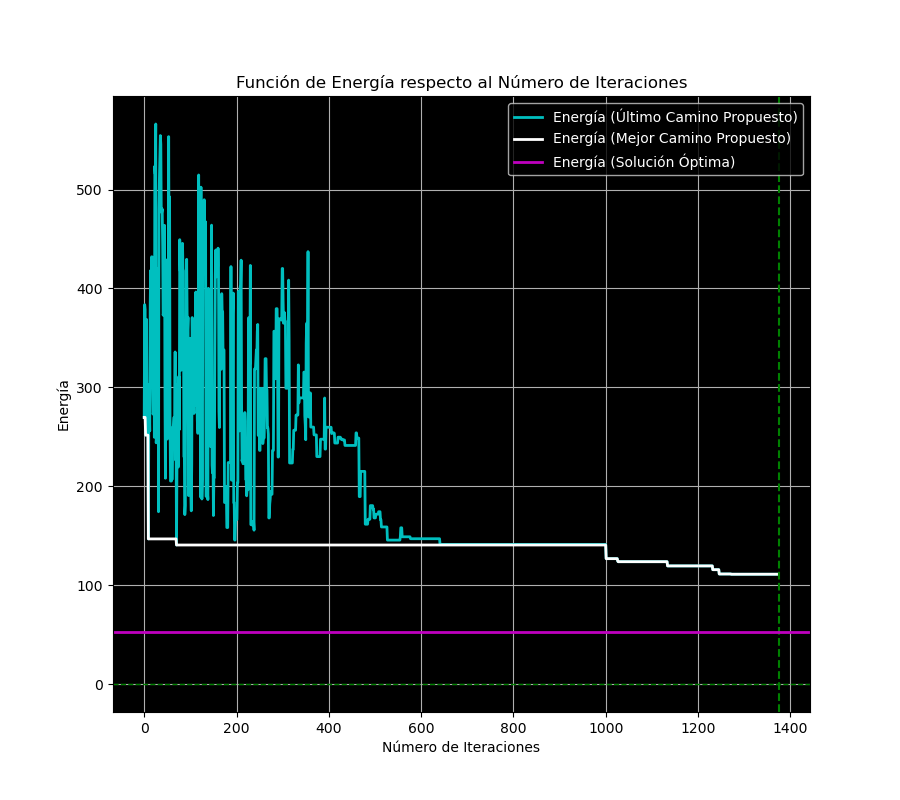

In [10]:
plt.figure(num = 3, figsize = (9, 8))
plt.plot(listaValoresEnergiaUltimaSolucionPropuesta, 'c-', label = "Energía (Último Camino Propuesto)", linewidth = 2)
plt.plot(listaValoresEnergiaMejorSolucionPropuesta, 'w-', label = "Energía (Mejor Camino Propuesto)", linewidth = 2)
plt.axvline(x = numeroIteraciones, color = 'g', linestyle = '--', linewidth = 1.5)
plt.axhline(y = 0.0, color = 'g', linestyle = '--', linewidth = 1)
plt.axhline(y = costoCaminoMasCortoOrigenADestino, color = 'm', linestyle = '-', label = "Energía (Solución Óptima)", linewidth = 2)
plt.title('Función de Energía respecto al Número de Iteraciones')
plt.xlabel('Número de Iteraciones')
plt.ylabel('Energía')
plt.legend(labelcolor = 'w', loc = 'upper right')
plt.grid(True)
plt.show()

In [11]:
endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución (Hasta esta parte): {} minuto(s) y {} segundo(s)".format(runningTimeInMinutes, runningTimeInSeconds))

Tiempo de Ejecución (Hasta esta parte): 20 minuto(s) y 10 segundo(s)


In [12]:
animationFilename = ""
if numeroIteraciones > 0:
    animationFilename = createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, nombreArchivoAnimacion, animationFileExtension, framesPorSegundoAnimacion)
    mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    print(printColouredText(mensajeConfirmacion, colorTextoRojo))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (748, 694) to (752, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Se ha(n) ajustado 1375 imágen(es) a un tamaño común que es de 748x694 como máximo de ancho por máximo de alto


[swscaler @ 0x5de7600] Warning: data is not aligned! This can lead to a speed loss


Se ha creado el archivo ./Figuras/Animación del Templado Simulado [Aproximación a Camino más Corto entre 2 Nodos].mp4
Hay 1375 archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


In [13]:
Video(animationFilename, width = 850)

In [14]:
textoMejorCaminoPropuestoOrigenADestino = crearTextoDescriptorSucesionElementos(listaPuntosMejorCaminoPropuestoOrigenADestino, separador = " -> ")
print("La mejor aproximación al camino más corto (o uno de los caminos de mínimo costo) obtenida, entre los puntos", printColouredText(str((coordenadaXPuntoInicial, coordenadaYPuntoInicial)), colorTextoVerde), "y", printColouredText(str((coordenadaXPuntoFinal, coordenadaYPuntoFinal)), colorTextoVerde), "es:")
print(printColouredText(textoMejorCaminoPropuestoOrigenADestino, colorTextoRojo))
print("La mejor aproximación al camino más corto (o uno de los caminos de mínimo costo) obtenida, entre los puntos", printColouredText(str((coordenadaXPuntoInicial, coordenadaYPuntoInicial)), colorTextoVerde), "y", printColouredText(str((coordenadaXPuntoFinal, coordenadaYPuntoFinal)), colorTextoVerde), "tiene una distancia total de", printColouredText(str(costoMejorCaminoPropuestoOrigenADestino), colorTextoVerde), "y pasa por", printColouredText(str(len(listaNodosMejorCaminoPropuestoOrigenADestino)), colorTextoVerde), "nodos")

La mejor aproximación al camino más corto (o uno de los caminos de mínimo costo) obtenida, entre los puntos (1, 2) y (22, 23) es:
(1, 2) -> (2, 2) -> (2, 3) -> (1, 3) -> (0, 3) -> (0, 2) -> (0, 1) -> (0, 0) -> (1, 0) -> (2, 0) -> (2, 1) -> (3, 1) -> (3, 0) -> (4, 0) -> (5, 0) -> (6, 0) -> (7, 0) -> (7, 1) -> (6, 1) -> (5, 1) -> (5, 2) -> (4, 2) -> (3, 2) -> (3, 3) -> (4, 3) -> (4, 4) -> (5, 4) -> (5, 5) -> (6, 5) -> (6, 4) -> (6, 3) -> (7, 3) -> (8, 3) -> (8, 4) -> (9, 4) -> (9, 5) -> (9, 6) -> (10, 6) -> (11, 6) -> (12, 6) -> (12, 5) -> (13, 5) -> (13, 6) -> (13, 7) -> (12, 7) -> (12, 8) -> (12, 9) -> (13, 9) -> (13, 10) -> (14, 10) -> (15, 10) -> (15, 11) -> (15, 12) -> (16, 12) -> (17, 12) -> (18, 12) -> (19, 12) -> (19, 13) -> (20, 13) -> (21, 13) -> (22, 13) -> (22, 14) -> (21, 14) -> (21, 15) -> (21, 16) -> (22, 16) -> (23, 16) -> (23, 17) -> (23, 18) -> (23, 19) -> (23, 20) -> (23, 21) -> (24, 21) -> (24, 22) -> (23, 22) -> (23, 23) -> (22, 23)
La mejor aproximación al camino má

In [15]:
endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución: {} minuto(s) y {} segundo(s)".format(runningTimeInMinutes, runningTimeInSeconds))

Tiempo de Ejecución: 20 minuto(s) y 32 segundo(s)
